# Importing Libraries

In [30]:
import os
import zipfile

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download & Explore Dataset

* Actual (25,000): https://www.kaggle.com/c/dogs-vs-cats

* Filtered (2,000) : https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [17]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-09-15 11:57:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   230MB/s    in 0.3s    

2021-09-15 11:57:39 (230 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [18]:
zipref = zipfile.ZipFile('/tmp/cats_and_dogs_filtered.zip', 'r')
zipref.extractall('/tmp')
zipref.close()

In [19]:
!ls /tmp | grep cats

cats_and_dogs_filtered
cats_and_dogs_filtered.zip


In [20]:
!ls /tmp/cats_and_dogs_filtered/

train  validation  vectorize.py


In [21]:
base_dir = '/tmp/cats_and_dogs_filtered/'

train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'validation/')

print(base_dir, train_dir, validation_dir)

/tmp/cats_and_dogs_filtered/ /tmp/cats_and_dogs_filtered/train/ /tmp/cats_and_dogs_filtered/validation/


In [22]:
!ls /tmp/cats_and_dogs_filtered/train/

cats  dogs


In [23]:
train_cats_dir = os.path.join(train_dir, 'cats/')
train_dogs_dir = os.path.join(train_dir, 'dogs/')

validation_cats_dir = os.path.join(validation_dir, 'cats/')
validation_dogs_dir = os.path.join(validation_dir, 'dogs/')

In [24]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

validation_cats_fnames = os.listdir(validation_cats_dir)
validation_dogs_fnames = os.listdir(validation_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])
print(validation_cats_fnames[:5])
print(validation_dogs_fnames[:5])

['cat.218.jpg', 'cat.193.jpg', 'cat.164.jpg', 'cat.418.jpg', 'cat.320.jpg']
['dog.33.jpg', 'dog.857.jpg', 'dog.648.jpg', 'dog.445.jpg', 'dog.136.jpg']
['cat.2440.jpg', 'cat.2369.jpg', 'cat.2138.jpg', 'cat.2334.jpg', 'cat.2361.jpg']
['dog.2399.jpg', 'dog.2078.jpg', 'dog.2158.jpg', 'dog.2236.jpg', 'dog.2249.jpg']


In [25]:
print('Total Training cat images: ', len(train_cats_fnames))
print('Total Training dog images: ', len(train_dogs_fnames))
print('Total validation cat images: ', len(validation_cats_fnames))
print('Total validation dog images: ', len(validation_dogs_fnames))


Total Training cat images:  1000
Total Training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500


# Visualize Images

In [26]:
nrows = 4
ncols = 4
pic_index = 0

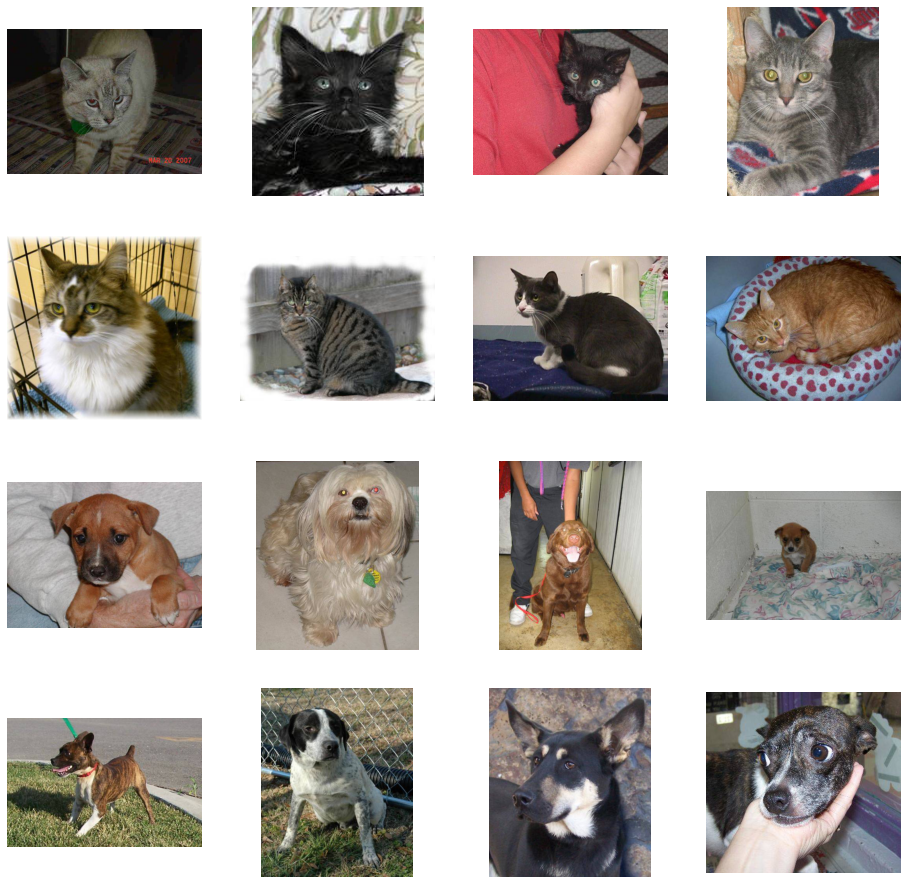

In [27]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_cat_pics = [os.path.join(train_cats_dir, fname) for fname in train_cats_fnames[pic_index-8:pic_index]]
next_dog_pics = [os.path.join(train_dogs_dir, fname) for fname in train_dogs_fnames[pic_index-8:pic_index]]

for i, image_path in enumerate(next_cat_pics + next_dog_pics):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')

  img = mpimg.imread(image_path)
  plt.imshow(img)

plt.show()

# Data Preprocessing

In [32]:
train_data_gen = ImageDataGenerator(rescale=1/255.0)
validation_data_gen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_data_gen.flow_from_directory(directory=train_dir,
                                                     target_size=(150, 150),
                                                     class_mode='binary',
                                                     batch_size=20)

validation_generator = validation_data_gen.flow_from_directory(directory=validation_dir,
                                                          target_size=(150, 150),
                                                          class_mode='binary',
                                                          batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Design and Train the Model

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [33]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics =['accuracy']
)

In [35]:
len(train_generator), len(validation_generator)

(100, 50)

In [36]:
history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/15
100/100 [==============================] - 59s 580ms/step - loss: 0.7681 - accuracy: 0.5625 - val_loss: 0.6396 - val_accuracy: 0.5980
Epoch 2/15
100/100 [==============================] - 58s 579ms/step - loss: 0.6116 - accuracy: 0.6795 - val_loss: 0.5812 - val_accuracy: 0.7150
Epoch 3/15
100/100 [==============================] - 59s 588ms/step - loss: 0.5218 - accuracy: 0.7430 - val_loss: 0.6916 - val_accuracy: 0.6710
Epoch 4/15
100/100 [==============================] - 58s 576ms/step - loss: 0.4455 - accuracy: 0.7945 - val_loss: 0.6606 - val_accuracy: 0.6910
Epoch 5/15
100/100 [==============================] - 58s 585ms/step - loss: 0.3604 - accuracy: 0.8375 - val_loss: 0.6254 - val_accuracy: 0.7240
Epoch 6/15
100/100 [==============================] - 58s 576ms/step - loss: 0.2713 - accuracy: 0.8870 - val_loss: 0.7072 - val_accuracy: 0.7140
Epoch 7/15
100/100 [==============================] - 58s 579ms/step - loss: 0.2098 - accuracy: 0.9125 - val_loss: 0.7986 - val_ac

In [37]:
model.evaluate(validation_generator)

50/50 [==============================] - 8s 166ms/step - loss: 1.6965 - accuracy: 0.7170


[1.6964613199234009, 0.7170000076293945]

# Visualize Intermediate Representation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


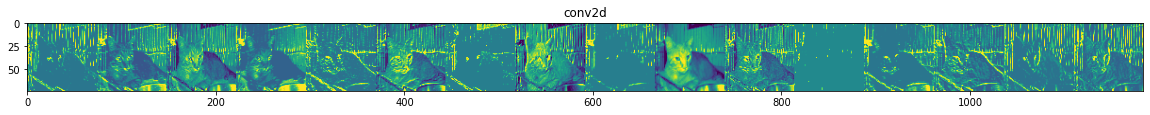

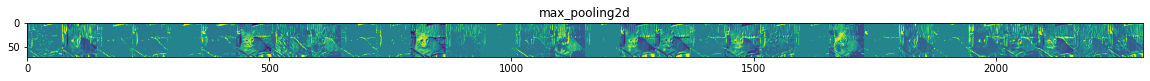

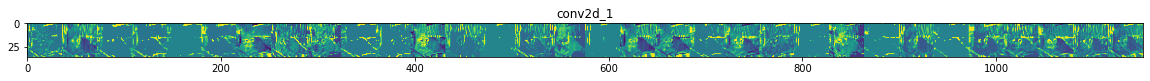

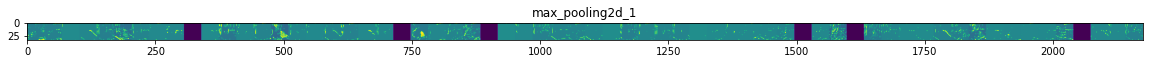

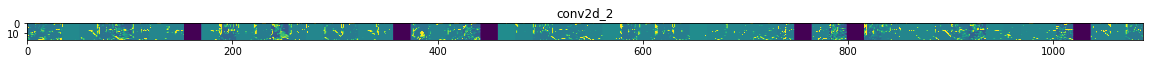

In [39]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cats_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dogs_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# Evaluate LOSS & ACCURACY

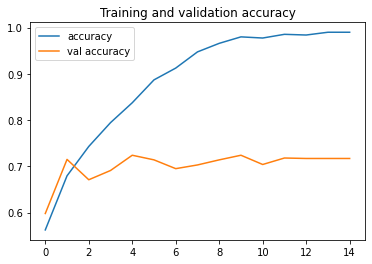

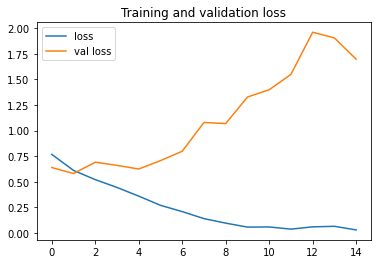

In [44]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc , label='accuracy')
plt.plot  ( epochs, val_acc , label='val accuracy')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label='loss')
plt.plot  ( epochs, val_loss , label='val loss')
plt.title ('Training and validation loss'   )
plt.legend()

# Testing the Model

In [45]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

Saving dog.jpeg to dog.jpeg
Saving cat.jpg to cat.jpg
[1.]
dog.jpeg is a dog
[0.]
cat.jpg is a cat
